In [1]:
import osmnx as ox
import networkx as nx
import pandas as pd
import numpy as np
import geopandas as gpd

import matplotlib.pyplot as plt

In [2]:
G = ox.graph_from_place('Bangladesh', network_type='drive')

In [3]:
N, E = ox.graph_to_gdfs(G)

N = N.to_crs(3857)
E = E.to_crs(3857)

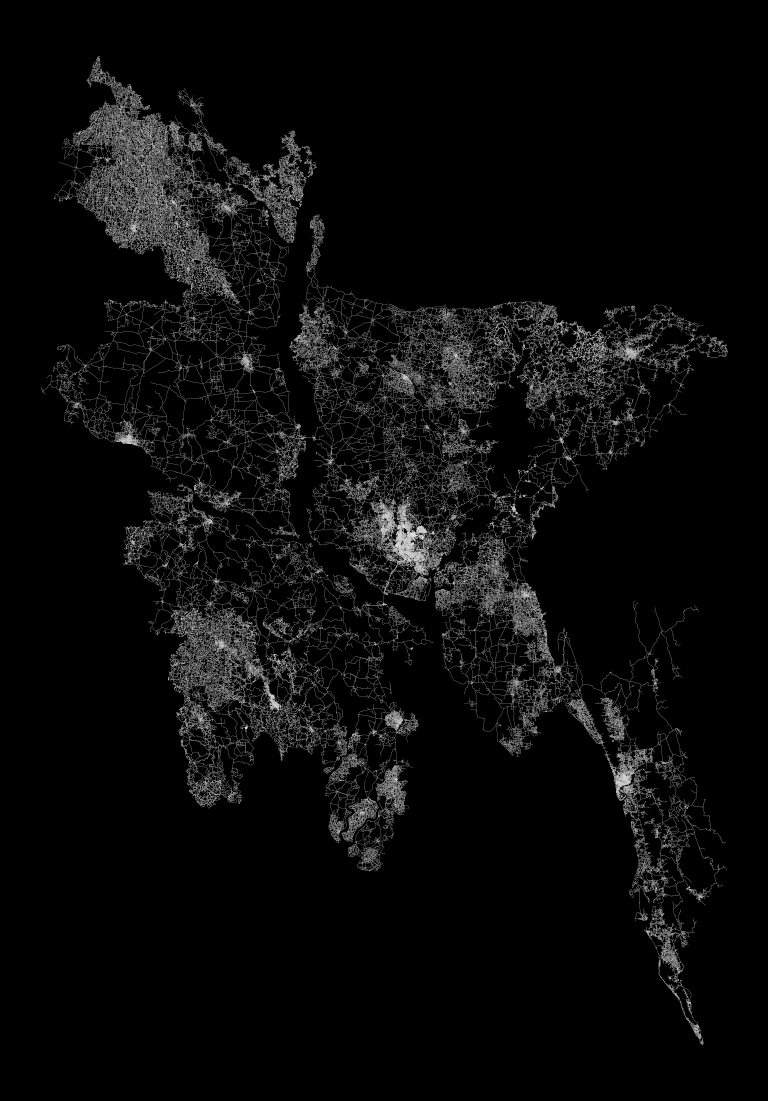

In [4]:
fig, ax = plt.subplots(1, 1, figsize = (20, 20), facecolor = 'k')

E.plot(color='w', ax=ax, linewidth=0.1)
ax.set_axis_off()
ax.set_facecolor('k')

In [32]:
E[ox.io._stringify_nonnumeric_cols(E).name.str.contains("বঙ্গবন্ধু সেতু")].explore()

In [56]:
dhaka = ox.geocoder.geocode("Dhaka, Bangladesh")
dhaka = ox.distance.nearest_nodes(G, dhaka[1], dhaka[0], return_dist=False)

In [59]:
from colorcet import palette
from matplotlib import colors

col = colors.LinearSegmentedColormap.from_list("bmw", palette['bmw'][::-1])

In [77]:
bridge = E[ox.io._stringify_nonnumeric_cols(E).name.str.contains("বঙ্গবন্ধু সেতু")].reset_index()

In [87]:
G_cut = G.copy()

G_cut.remove_edge(bridge.iloc[0]['u'], bridge.iloc[0]['v'])
G_cut.remove_edge(bridge.iloc[1]['u'], bridge.iloc[1]['v'])

In [140]:
N_cut, E_cut = ox.graph_to_gdfs(G_cut)

E_cut = E_cut.to_crs(3857)
N_cut = N_cut.to_crs(3857)

In [88]:
%time pre_isolines = nx.single_source_dijkstra(G_cut, dhaka, weight='length')

CPU times: user 4.21 s, sys: 393 ms, total: 4.6 s
Wall time: 4.61 s


In [93]:
 pre_distances = pd.DataFrame({'osmid': pre_isolines[0].keys(), 'distance': pre_isolines[0].values()})

In [96]:
import mapclassify as mc

In [97]:
q10 = mc.Quantiles(pre_distances.distance, k=10)

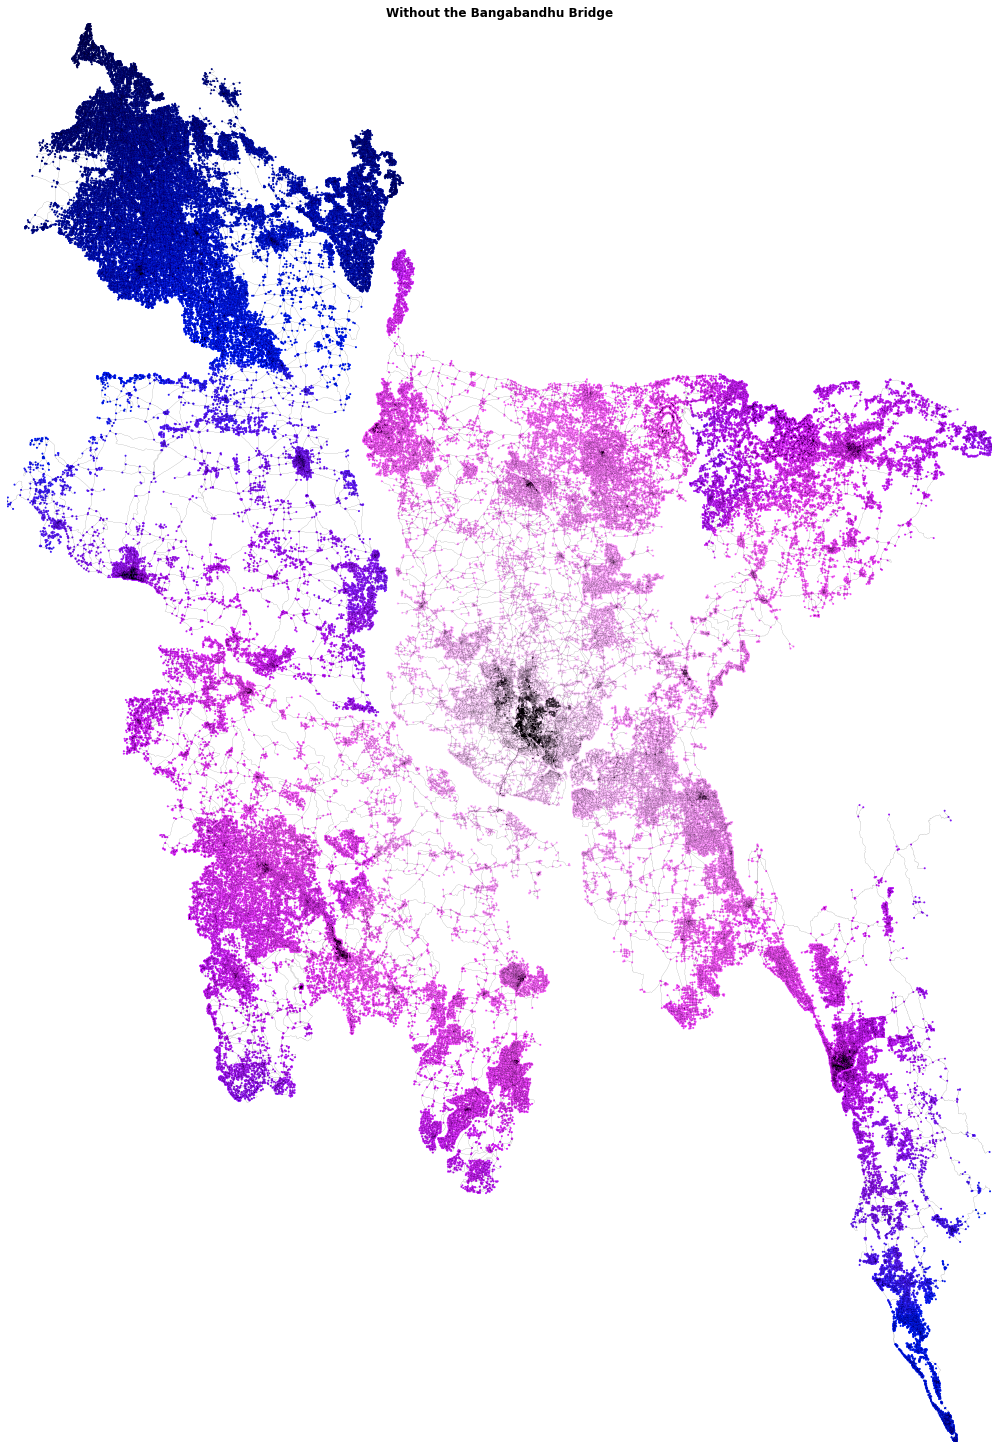

In [143]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20), 
                       constrained_layout=True, 
                       subplot_kw=dict(aspect='equal'))

E_cut.plot(color='k', linewidth=0.05, ax=ax)

N_cut.merge(pre_distances.assign(cl=q10.yb), 
            left_on='osmid', 
            right_on='osmid', 
            how='left').to_crs(3857).plot('distance', markersize=1, cmap=col, ax=ax,
                                         vmin=pre_distances.distance.min(),
                                         vmax=pre_distances.distance.max())

ax.set_xlim((N.geometry.x.min(), N.geometry.x.max()))
ax.set_ylim((N.geometry.y.min(), N.geometry.y.max()))

ax.set_title("Without the Bangabandhu Bridge", color='k', weight='bold')

ax.set_axis_off()

fig.savefig('without_bridge.png', facecolor=fig.get_facecolor(), dpi=300, bbox_inches='tight')

In [132]:
%time post_isolines = nx.single_source_dijkstra(G, dhaka, weight='length')

CPU times: user 4.87 s, sys: 406 ms, total: 5.28 s
Wall time: 5.28 s


In [133]:
post_distances = pd.DataFrame({'osmid': post_isolines[0].keys(), 'distance': post_isolines[0].values()})

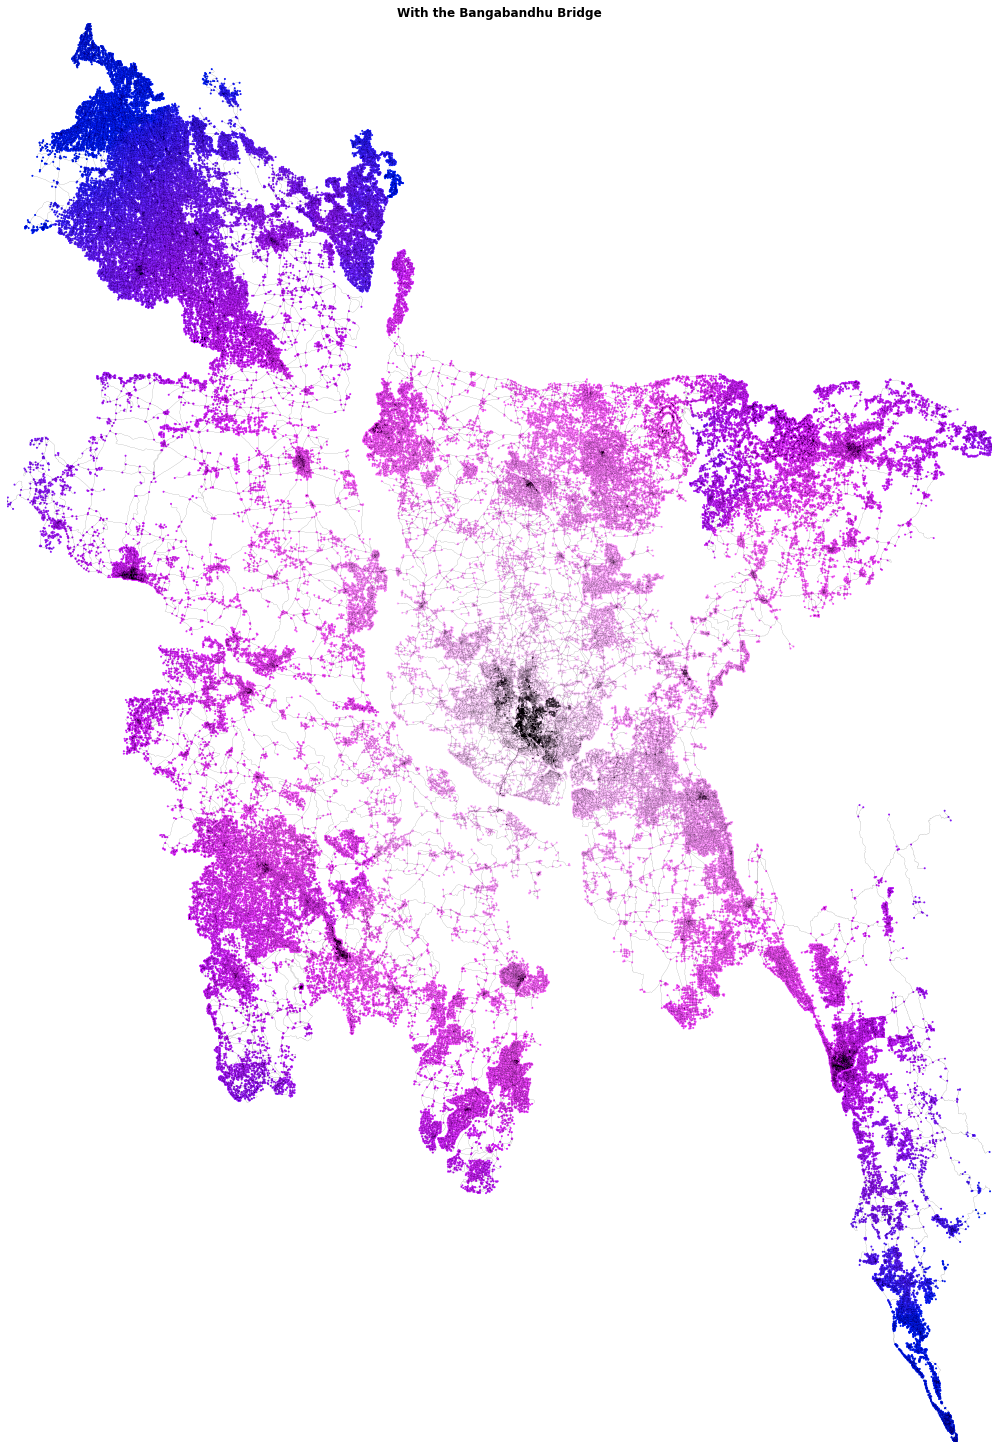

In [144]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20), 
                       constrained_layout=True, 
                       subplot_kw=dict(aspect='equal'))

E.plot(color='k', linewidth=0.05, figsize=(20, 20), ax=ax)

N.merge(post_distances.assign(cl=q10.yb), 
        left_on='osmid', 
        right_on='osmid', 
        how='left').to_crs(3857).plot('distance', markersize=1, cmap=col, ax=ax,
                                     vmin=pre_distances.distance.min(),
                                     vmax=pre_distances.distance.max())

ax.set_xlim((N.geometry.x.min(), N.geometry.x.max()))
ax.set_ylim((N.geometry.y.min(), N.geometry.y.max()))

ax.set_title("With the Bangabandhu Bridge", color='k', weight='bold')

ax.set_axis_off()

fig.savefig('with_bridge.png', facecolor=fig.get_facecolor(), dpi=300, bbox_inches='tight')